In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from utils.predictiveNet import PredictiveNet
import matplotlib.pyplot as plt
import numpy as np
from utils.general import saveFig
import itertools
import torch
import random
from utils.agent import RandomActionAgent
from analysis.representationalGeometryAnalysis import representationalGeometryAnalysis
from analysis.SpatialTuningAnalysis import SpatialTuningAnalysis



In [3]:
savefolder = 'Figures/S13_ObservationActionRepresentation/'

In [4]:
seed = 102

In [5]:
#Example Net
netname = 'AutoencoderPred_LN'
#netname_1mask = 'thRNN_1win'
#exseed = 8
#netfolder = '/multisteptest/'
exseed = seed
netfolder = '/Autoencoder_sparse_panel/'
predictiveNet_NS = PredictiveNet.loadNet(netfolder+netname+'-Onehot-s'+str(exseed))

Net Loaded from pathname


In [6]:
#Example Net
netname = 'thRNN_1win'
#netname_1mask = 'thRNN_1win'
#exseed = 8
#netfolder = '/multisteptest/'
exseed = seed
netfolder = '/maskedk_panel/'
predictiveNet_k1 = PredictiveNet.loadNet(netfolder+netname+'-SpeedHD-s'+str(exseed))

Net Loaded from pathname


In [7]:
#Example Net
netname = 'thRNN_5win'
#netname_1mask = 'thRNN_1win'
#exseed = 8
#netfolder = '/multisteptest/'
exseed = seed
netfolder = '/maskedk_panel/'
predictiveNet_k5 = PredictiveNet.loadNet(netfolder+netname+'-SpeedHD-s'+str(exseed))

Net Loaded from pathname


In [9]:
RGA_NS = representationalGeometryAnalysis(predictiveNet_NS, timesteps_sleep=10, timesteps_wake = 15000, withIsomap = False)
RGA_k1 = representationalGeometryAnalysis(predictiveNet_k1, timesteps_sleep=10, timesteps_wake = 15000, withIsomap = False)
RGA_k5 = representationalGeometryAnalysis(predictiveNet_k5, timesteps_sleep=10, timesteps_wake = 15000, withIsomap = False)


Running WAKE


/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/representationalGeometryAnalysis.py:313: RuntimeWarning: invalid value encountered in divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Running SLEEP
Running WAKE
Running SLEEP
Running WAKE
Running SLEEP


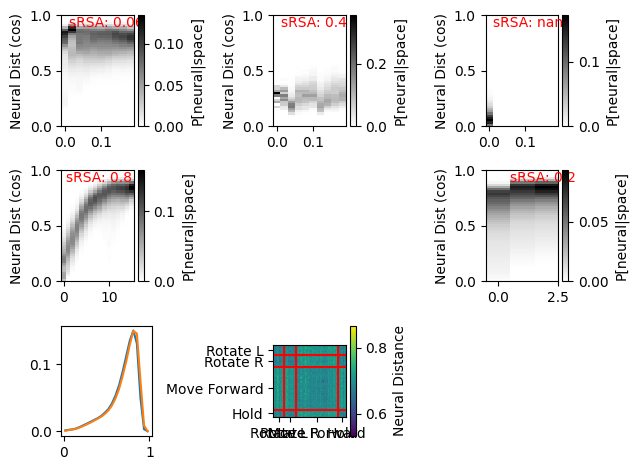

In [29]:
RGA_k5.AllRSAFigure('k5',savefolder)

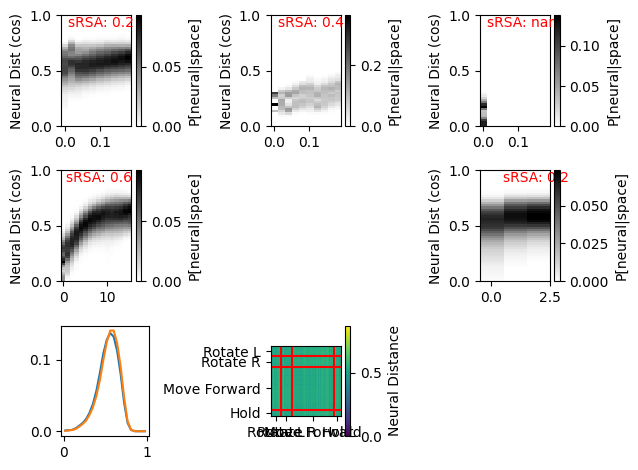

In [11]:
RGA_k1.AllRSAFigure('k1',savefolder)

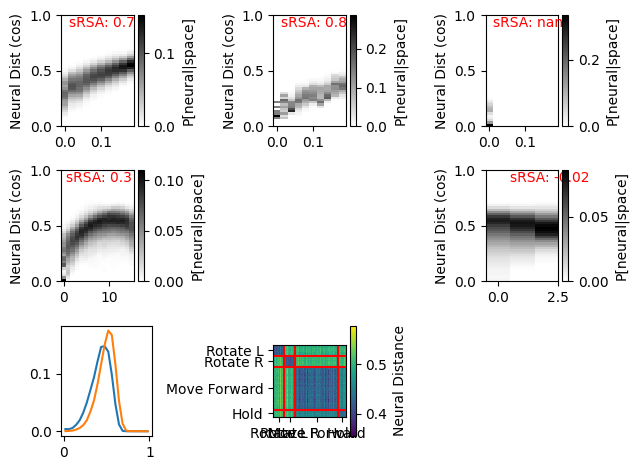

In [30]:
RGA_NS.AllRSAFigure('NS',savefolder)

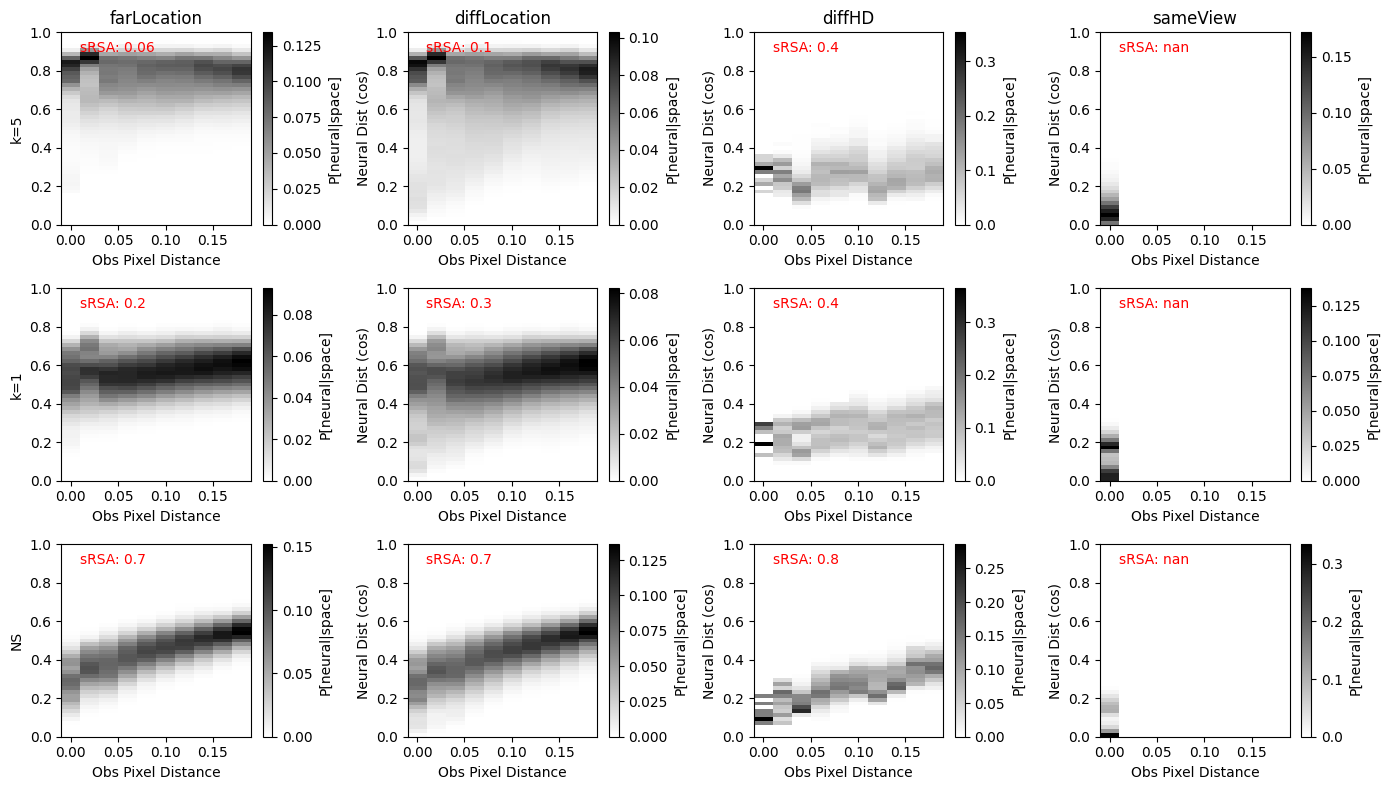

In [32]:
names = ['k=5','k=1','NS']
plt.figure(figsize=(14,8))
for nidx, net in enumerate([RGA_k5.RSA_obs,RGA_k1.RSA_obs,RGA_NS.RSA_obs]):
    for idx, (key, value) in enumerate(net.items()):
        plt.subplot(3,4,1+idx+(nidx*4))
        RGA_k5.spatialRSApanel(value,'cos')
        plt.xlabel('Obs Pixel Distance')
        if nidx==0:
            plt.title(key)
        if idx==0:
            plt.ylabel(names[nidx])
        
plt.tight_layout()
saveFig(plt.gcf(),'InputDistance',savefolder,
        filetype='pdf')
plt.show()

In [8]:
nettypes = ['thRNN']
kvalues = ['0','1','2','3','4','5','6']
masks = ['']
#seeds = ['30','31','32','33','34','35']
seeds = ['100','101','102','103','104','105','106','107','108']
aEncs = ['Onehot','SpeedHD','Velocities']

netprops = itertools.product(*[nettypes,['_'],kvalues,['win'],masks,['-'],aEncs,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = ['Mask k'+name[2] for name in netprops]
netmask = [name[4] for name in netprops]
netAE = [name[6] for name in netprops]
netseed = [int(name[8]) for name in netprops]

netk = [int(name[2]) for name in netprops]
netfolder = '/maskedk_panel/'

analysisFrame_kpanel = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'mask':netmask, 'k':netk,
                                   'ActionEnc':netAE, 'seed':netseed, 'netfolder':netfolder})

In [9]:
nettypes = ['AutoencoderPred_LN']
aEncs = ['Onehot','SpeedHD','Velocities']
#seeds = ['0','2','3','4','5']
#seeds = ['0','2','3','4','5']
#seeds = ['0','1','3','4','5']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],aEncs,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netAE = [name[2] for name in netprops]
netseed = [int(name[4]) for name in netprops]
netfolder = '/Autoencoder_sparse_panel/'


analysisFrame_sparse = pd.DataFrame(data={'filename':netnames, 'type':'N-S (+LN)', 'ActionEnc':netAE, 'seed':netseed,
                                      'netfolder':netfolder})

In [10]:
analysisFrame = pd.concat([analysisFrame_sparse, analysisFrame_kpanel])

In [11]:

def loadNet(row):
    try:
        net = PredictiveNet.loadNet(row['netfolder']+row['filename'],suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        net = PredictiveNet
        

analysisFrame['net'] = analysisFrame.apply(loadNet, axis = 1)

In [12]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    predictiveNet = loadNet(row)
    #print(len(predictiveNet.TrainingSaver['sRSA'].values))
    try:
        SI = predictiveNet.TrainingSaver['SI'].values[-1]
        sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]

        EVs = predictiveNet.TrainingSaver['EVs'].values[-1]
        
        SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    except:
        SI = predictiveNet.TrainingSaver['SI']
        sRSA = predictiveNet.TrainingSaver['sRSA']

        EVs = predictiveNet.TrainingSaver['EVs']
        
        SWdist = predictiveNet.TrainingSaver['SWdist']
        finalLoss = predictiveNet.TrainingSaver['loss']
        
    meanSI = np.nanmean(SI)
    EVsp50 = np.nanmean(EVs>0.5)
    tunedSI = np.nanmean(SI[EVs>0.5])
    
    return SI, meanSI, sRSA, EVs, EVsp50, finalLoss, SWdist, tunedSI
analysisFrame[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI']] = analysisFrame.apply(getSpatialRep, axis = 1, result_type="expand")

In [14]:
def getRSA(row):
    predictiveNet = loadNet(row)
    
    #RGA = representationalGeometryAnalysis(predictiveNet, timesteps_sleep=0, withIsomap=False)
    #RSA_HD = RGA.RSA_HD[0][0]
    #RSA_obs_far = RGA.RSA_obs['farLocation'][0][0]
    #RSA_obs_diffHD = RGA.RSA_obs['diffHD'][0][0]
    #RSA_act = RGA.actEncode_cs[0][0]
    #RSA_space = RGA.RSA_cs[0][0]
    
    RSA_HD = predictiveNet.TrainingSaver['RSA_HD'].values[-1]
    RSA_obs_far = predictiveNet.TrainingSaver['RSA_obs_far'].values[-1]
    RSA_obs_diffHD = predictiveNet.TrainingSaver['RSA_obs_diffHD'].values[-1]
    RSA_act = predictiveNet.TrainingSaver['RSA_act'].values[-1]
    RSA_space = predictiveNet.TrainingSaver['RSA_eu_space'].values[-1]
    
    return RSA_space, RSA_act, RSA_HD, RSA_obs_far, RSA_obs_diffHD

analysisFrame[['RSA_space','RSA_act','RSA_HD','RSA_obs_far','RSA_obs_diffHD']] = analysisFrame.apply(getRSA, axis = 1, result_type="expand")

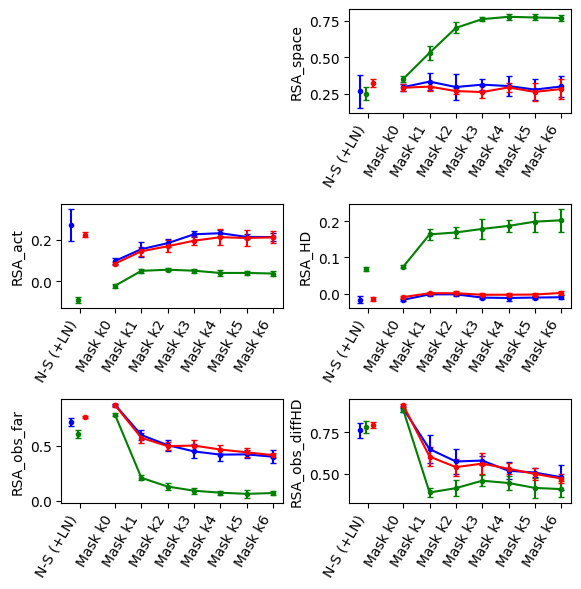

In [16]:
#CANN_sRSA = RGA_CANN.RSA_cs[0][0]
#CANN_SW = RGA_CANN.SWdist_cs[0]
#stats: all nets, mean SI, p50, sRSA, SWDist (compare action encodings), mean+/- std over seeds
#example nets: SI distribution and EV distribution (Speed+HD all)
examplenets = (analysisFrame['ActionEnc']=='SpeedHD') & (analysisFrame['seed']==0)
plt.figure(figsize=(6,6))

maskedidx = np.arange(1,8)
NSidx = np.arange(0,1)
colors = ['blue','green','red','purple']
metrics = ['RSA_space','RSA_act','RSA_HD','RSA_obs_far','RSA_obs_diffHD']
for aidx,act in enumerate(analysisFrame['ActionEnc'].unique()):
    data = analysisFrame[analysisFrame['ActionEnc']==act][metrics+['type']]
    panel = data.groupby('type',sort=False).agg([np.mean, np.std])


    for idx,metric in enumerate(metrics):   
        plt.subplot(3,2,2+idx)
        plt.errorbar(maskedidx,panel[metric]['mean'][maskedidx], 
                         panel[metric]['std'][maskedidx],
                    capsize=2,fmt='.-',color=colors[aidx],label=act)
        plt.errorbar(NSidx+0.25*aidx-0.66,panel[metric]['mean'][NSidx], 
                         panel[metric]['std'][NSidx],
                    capsize=2,fmt='.',color=colors[aidx])
        plt.ylabel(metric)
        plt.gca().set_xticks(np.concatenate([NSidx-0.33,maskedidx]), labels=panel.index)
        plt.xticks(rotation=60, ha='right')
        #if metric == 'sRSA':
        #    plt.plot([NSidx[0]-0.33,maskedidx[-1]],[CANN_sRSA,CANN_sRSA],'k--')
        #if metric == 'SWdist':
        #    #plt.plot([NSidx[0]-0.33,maskedidx[-1]],[CANN_SW,CANN_SW],'k--')
        #if idx==1:
        #    plt.legend(fontsize='xx-small')


plt.tight_layout()

saveFig(plt.gcf(),'AllRSA',savefolder,
        filetype='pdf')

plt.show()